# Projet 6 : Implémentez un modèle de scoring

L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel.

Ce notebook se présente de la manière suivante :

Différents modèles de ML sont testés rapidement et le plus prometteur est sélectionné.

Ensuite, une fonction d'optimisation via la librairie "hyperopt" est définie. Elle a permis d'optimiser des paramètres suivant deux métriques différentes: la métrique technique f1_score et une métrique bancaire faite sur mesure pour notre problème. Les paramètres optimisés sont ceux du modèle ML ainsi que le seuil de solvabilité Les résultats ont été comparés et la métrique bancaire s'est avérée très pertinente.

Dans une dernière partie, le modèle final ainsi que la méthode LIME ont permis d'étudier quelles étaient les variables les plus influentes sur la  prédiction de la solvabilité d'un client, d'un point de vue global puis local i.e pour un client spécifique.

## Table des matières

* [4. Séléction d'un modèle Machine Learning](#partie4)
    * [4.1 Transformation des données](#Section_4_1)
    * [4.1 Séléction du meilleur modèle](#Section_4_2)
    
* [5. Optimisation des hyper-paramètres](#partie5)
    * [5.1 Fonction d'optimisation pour le choix des hyper-paramètres](#Section_5_1)
    * [5.2 Optimisation métrique métier](#Section_5_2)
    * [5.3 Optimisation métrique technique : roc_auc](#Section_5_3)
    * [5.4 Comparaison des résultats pour les deux métriques](#Section_5_4)
        * [5.4.1 Matrices de confusion](#sSection_5_4_1)
        * [5.4.2 Précision, rappel et roc_auc](#sSection_5_4_2)
* [6. Importance des features](#partie6)
    * [6.1 Importance globable des features](#Section_6_1)
    * [6.2 Analyse locale globable des features](#Section_6_1)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Chargement des librairies

In [ ]:
pip install featuretools

     |████████████████████████████████| 339 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 16.9 MB/s 
     |████████████████████████████████| 11.3 MB 9.1 MB/s 
     |████████████████████████████████| 280 kB 42.2 MB/s 
     |████████████████████████████████| 830 kB 38.9 MB/s 
     |████████████████████████████████| 160 kB 46.1 MB/s 
     |████████████████████████████████| 15.7 MB 40.8 MB/s 
     |████████████████████████████████| 596 kB 33.5 MB/s 
     |████████████████████████████████| 133 kB 46.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Atte

In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 6.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=874a77b252bab8df1e81f4ce6f0aa15de6ec0cb55c569aa569211add23d77088
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# Load packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Feature engineering
import featuretools as ft
from featuretools import selection

# Package pour augmenter la data
from imblearn.over_sampling import SMOTE

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from lime.lime_tabular import LimeTabularExplainer
from sklearn.neighbors import NearestNeighbors

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Modèles de ML
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet

color = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

from sklearn.metrics import auc
from sklearn.metrics import roc_curve


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

Output hidden; open in https://colab.research.google.com to view.

#### Lecture des données

In [ ]:
# Lecture des données finales pour le modèle
app = pd.read_csv("/content/drive/MyDrive/P7_credit/output/app_encoded.csv", sep=',',
                  index_col=0, encoding='utf8')

# Lecture des données brutes (non encodés et sans 'feature engineering')
app_no_encoded = pd.read_csv("/content/drive/MyDrive/P7_credit/output/app_no_enconded_featureengineering.csv")

In [ ]:
# Set SK_ID_CURR as index
app.set_index('SK_ID_CURR' ,inplace=True)
app_no_encoded.set_index('SK_ID_CURR' ,inplace=True)

## 4. Séléction d'un modèle Machine Learning <a class="anchor" id="partie4"></a>

In [ ]:
app.head(5)

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,WEEKDAY_APPR_PROCESS_START_1_-0.9009688679024191,WEEKDAY_APPR_PROCESS_START_1_1.0,WEEKDAY_APPR_PROCESS_START_1_-0.2225209339563146,WEEKDAY_APPR_PROCESS_START_1_0.6234898018587334,WEEKDAY_APPR_PROCESS_START_1_-0.900968867902419,WEEKDAY_APPR_PROCESS_START_1_0.6234898018587336,WEEKDAY_APPR_PROCESS_START_1_-0.22252093395631434,WEEKDAY_APPR_PROCESS_START_1_nan,WEEKDAY_APPR_PROCESS_START_2_-0.433883739117558,WEEKDAY_APPR_PROCESS_START_2_0.0,WEEKDAY_APPR_PROCESS_START_2_-0.9749279121818236,WEEKDAY_APPR_PROCESS_START_2_-0.7818314824680299,WEEKDAY_APPR_PROCESS_START_2_0.43388373911755823,WEEKDAY_APPR_PROCESS_START_2_0.7818314824680298,WEEKDAY_APPR_PROCESS_START_2_0.9749279121818236,WEEKDAY_APPR_PROCESS_START_2_nan
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,...,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Divise app en jeu test et entrainement
train_set = app.loc[~app['Test'], :]
test_set = app.loc[app['Test'], :]

# Ensure all data is stored as floats
train_set = train_set.astype(np.float64)
train_set.drop(columns=["Test"], inplace=True)
test_set = test_set.astype(np.float64)
test_set.drop(columns=["Test"], inplace=True)

# Target labels
y_train = train_set['TARGET']
y_test = test_set["TARGET"]

# Remove test/train indicator column and target column
x_train = train_set.drop(columns=['TARGET'])
x_test = test_set.drop(columns=['TARGET'])

### 4.1 Transformation des données <a class="anchor" id="Section_4_1"></a>

Pipeline d'imputation des valeurs manquantes et standardisation

In [ ]:
# Pipeline de standardisation et d'imputation des valeurs manquantes
var_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

Sépération du jeu d'entrainement en entrainement puis validation

In [ ]:
# On split le jeu d'entrainement en entrainement et test
train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

Sauvegarde des données

In [ ]:
# Sauvegarde des jeux de données d'entrainement et de validation
train_set.to_csv("/content/drive/MyDrive/P7_credit/output/app_train.csv")
valid_set.to_csv("/content/drive/MyDrive/P7_credit/output/app_valid.csv")

### 4.2 Séléction du meilleur modèle <a class="anchor" id="Section_4_2"></a>

#### Liste des classifieurs étudiés

In [ ]:
# Dictionnaire de classifieurs 
classifiers_1 = { 'Dummy Classifier': DummyClassifier(),
                  'Logistic Regression': LogisticRegression(),
                  'Random Forest': RandomForestClassifier(n_estimators=100),
                  'Multi-layer Perceptron': MLPClassifier(),
                  'Xgboost': XGBClassifier(),
                  'LGBM': LGBMClassifier()
              }

#### Séléction du meilleur classifieur : métrique technique roc_auc

In [ ]:
# Pipeline de transformations + classification
def define_pipeline(preprocessor, classifier) :
    
    pipe = Pipeline([("preprocess", preprocessor),
                     ("regressor", classifier),
                    ])
    return pipe

In [ ]:
def plot_roc_curve(classifiers, var_pipeline, X, y, n_splits=5, fit=True):

    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            full_pipeline = define_pipeline(var_pipeline, clf)
            
            if fit :
                full_pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = full_pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Dummy Classifier
Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

Random Forest
Multi-layer Perceptron
Xgboost
LGBM


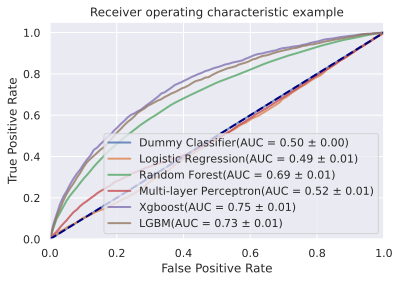

In [ ]:
# Affichage de la courbe ROC pour les différents modèles testés
plot_roc_curve(classifiers_1, var_pipeline, train_set.drop(columns="TARGET"), train_set["TARGET"])

## 5. Optimisation des hyper-paramètres <a class="anchor" id="partie5"></a>

Il s'agit d'une classification binaire 0 ou 1, solvable ou non, négatif ou positif.

<img src="tp_fn.png">

Les individus dont la valeur cible réelle est 0 et dont la prédiction est 0 sont les 'True Negatives' dits aussi 'TN'

Les individus dont la valeur cible réelle est 0 alors que la prédiction est 1 sont les 'False Negatives' appelés aussi 'FN'

Les individus dont la valeur cible réelle est 1 alors que la prédiction est 0 sont les 'False Positives' appelés aussi 'FP'

Les individus dont la valeur cible réelle est 1 et dont la prédiction est 1 sont les 'True Positives' appelés aussi 'TP'

### 5.1 Fonction d'optimisation pour le choix des hyperparamètres <a class="anchor" id="Section_5_1"></a>

In [ ]:
skf = StratifiedKFold(n_splits=5)
def model_v1(predictor, pipeline, features, eval_metric, cv=skf):
    
    
    # Extract the ids
    train_ids = features.index

    # Extract the targets for training
    targets = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns=['TARGET'])
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Apply the pipeline
    features = pipeline.fit_transform(features)
    targets = np.array(targets)    
    
    # Increase the data to get a bigger proportion of positif targets
    sm = SMOTE(random_state=42, sampling_strategy=0.2) # the ratio is chosen
    # to correspond to the pareto law with the 80%/20% ratio
    features_res, targets_res = sm.fit_resample(features, targets.ravel())  

    def optim_score(params,
                    model=predictor,
                    x_train=features_res,
                    y_train=targets_res,
                    cv=cv,
                    eval_metric=eval_metric):

        # the function gets a set of variable parameters in "param"
        params_model = {'n_estimators': int(params['n_estimators']), 
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda'],
        }

        # asssigne les paramètres du modèle
        model.set_params(**params_model)
        
        # Seuil de solvabilité
        threshold = params['solvability_threshold']

        # Cross-validation à 5 passes : retourne le score de probabilité
        y_proba = cross_val_predict(model,
                                    x_train,
                                    y_train,
                                    method='predict_proba',
                                    cv=cv)[:, 1]
       
        # Si proba > seuil alors la prédiction est positive : 1
        y_pred = (y_proba > threshold)
        y_pred = np.array(y_pred > 0) * 1
        
        # Calcul du score suivant la métrique utilisé
        score = eval_metric(y_train, y_pred)

        return 1 - score # Retourne le score

 
    # possible values of parameters
    space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
           'max_depth' : hp.quniform('max_depth', 2, 30, 2),
           'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
           'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
           'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
           'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
           'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
           'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
           'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
    }


    best=fmin(fn=optim_score, # function to optimize
              space=space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=10, # maximum number of iterations
    )

    # computing the score on the test set
    predictor.set_params(
                   n_estimators=int(best['n_estimators']),
                   max_depth=int(best['max_depth']),
                   learning_rate=best['learning_rate'],
                   subsample=best['subsample'],           
                   colsample_bytree=best['colsample_by_tree'],
                   num_leaves=int(best['num_leaves']),
                   reg_alpha=best['reg_alpha'],
                   reg_lambda=best['reg_lambda'],
                    
    )
    
    # Entrainement du modèle sur tout le jeux de données
    predictor.fit(features, targets)

    # Record the best parameters
    best_parameters = best
    
    # Assemblage de pipeline
    full_pipeline = define_pipeline(pipeline, predictor)

    # Record the feature importances
    feature_importance_values = full_pipeline[-1].feature_importances_
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': feature_importance_values})

    return best_parameters, feature_importances, full_pipeline

### 5.2 Optimisation métrique métier <a class="anchor" id="Section_5_2"></a>

La métrique banking ici crée, consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données.

Pour cela nous avons fixé un poids arbitraire pour chacune des prédictions relativement à leurs valeurs réelles.

Les valeurs des poids sont les suivantes : 
    - fn_value = -10
    - tp_value = 0
    - tn_value = 1
    - fp_value = 0
    
De ce fait, les prêts accordés aux individus qui ne sont finalement pas solvables sont dotés d'une pénalisation négative de -10, alors que les prêts accordés aux individus finalement solvables rapportent 1. Ce rapport 10 est totalement arbitraire et il est tout à fait possible de changer ces valeurs à la convenance de l'optique métier. Il faudra cependant relancer l'optimisation des hyper-paramètres du modèle.

#### Définition de la métrique 'banking'

In [ ]:
def Ind_bank(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

In [ ]:
best_parameters_0, feature_importance_0, clf_0 = model_v1(LGBMClassifier(),
                                                          var_pipeline,
                                                          train_set,
                                                          eval_metric=Ind_bank)

100%|██████████| 10/10 [2:00:59<00:00, 725.97s/it, best loss: 0.25735196666028537]


In [ ]:
# Affichage des meilleurs hyper-paramètres
best_parameters_0

{'colsample_by_tree': 0.8,
 'learning_rate': 0.007282503755983172,
 'max_depth': 20.0,
 'n_estimators': 1600.0,
 'num_leaves': 80.0,
 'reg_alpha': 0.4,
 'reg_lambda': 0.30000000000000004,
 'solvability_threshold': 0.125,
 'subsample': 0.2}

Le meilleur seuil de solvabilité est de 0.1, i.e tous les individus dont les valeurs de prédictions sont inférieurs à 0.1 ne sont pas solvables.

#### Sauvegarde des résultats

In [ ]:
# Sauvegarde du modèle banking
pickle.dump(clf_0, open('/content/drive/MyDrive/P7_credit/output/banking_model.md', 'wb'))

#### Evolution du gain en fonction du seuil de solvabilité

In [ ]:
def gain_seuil(clf, y_set, x_set):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 20)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(Ind_bank(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))
    

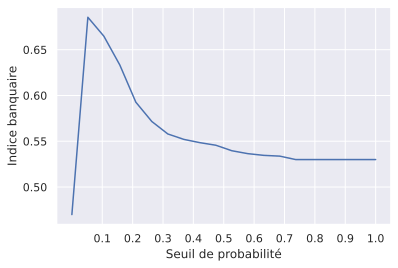

In [ ]:
# Affiche le meilleur seuil de probabilité
gain_seuil(clf_0, valid_set["TARGET"], valid_set.drop(columns=["TARGET"]))

On retrouve le fait que le meilleur seuil de solvabilité est de 0.1 comme celui trouvé par l'optimisation via hyperopt.

Le gain obtenu avec un seuil de 0.1 est plus conséquent que pour un seuil par défaut de 0.5 fixé par LGBM

### 5.3 Optimisation métrique technique :  f1_score <a class="anchor" id="Section_5_3"></a>

La métrique f1_score est la moyenne harmonique de la précision et du rappel.

<img src="f1_score.png">

Alors que la moyenne ordinaire traite de la même manière toutes les valeurs, la moyenne harmonique donne plus de poids aux faibles valeurs. Par conséquent, le classificateur n'obtiendra un bon score F1 que si son rappel et sa précision sont élevés

La précision est l'exactitude des prédictions positives :

- précision = TP / (TP + FP)

TP (abréviation de l'anglais True Positive) est le nombre de vrais positifs et FP est le nombre de faux positifs.

Quant au rappel, c'est le taux d'observations positives ayant été correctement détectées par le classficateur

- rappel = TP / (TP + FN)

FN est le nombre de faux positifs.

In [ ]:
# Optimisation pour la métrique 'roc_auc'
best_parameters_1, feature_importance_1, clf_1 = model_v1(LGBMClassifier(),
                                                          var_pipeline,
                                                          train_set,
                                                          eval_metric=f1_score)

100%|██████████| 10/10 [2:07:02<00:00, 762.27s/it, best loss: 0.2806821358680458]


In [ ]:
# Affichage des meilleurs hyper-paramètres
best_parameters_1

{'colsample_by_tree': 0.6000000000000001,
 'learning_rate': 0.00628050407060134,
 'max_depth': 14.0,
 'n_estimators': 1600.0,
 'num_leaves': 88.0,
 'reg_alpha': 0.2,
 'reg_lambda': 0.5,
 'solvability_threshold': 0.47500000000000003,
 'subsample': 0.6000000000000001}

#### Sauvegarde des résultats

In [ ]:
filename = '/content/drive/MyDrive/P7_credit/output/banking_model_f1.md'
# Sauvegarde du modèle
pickle.dump(clf_1, open(filename, 'wb'))

### 5.4 Comparaison des résultats pour les deux métriques <a class="anchor" id="Section_5_4"></a>

#### 5.4.1 Matrices de confusion <a class="anchor" id="sSection_5_4_1"></a>

Fonction permettant d'afficher plusieurs matrices de confusions en fonctions des différentes prédictions

In [ ]:
def plot_heatmap_confusion(y_valid, **y_valid_pred):
    
    plt.figure(1, figsize=(12, 4))
    results = {}
    
    j = 1
    for i, y_pred in y_valid_pred.items():
        
        plt.subplot(1, len(y_valid_pred), j)

        conf_mx = confusion_matrix(y_valid, y_pred)
        results[i] = conf_mx
        mat_conf_df = pd.DataFrame(conf_mx,
                                   columns=["Solvable", "Non Solvable"],
                                   index=["Solvable", "Non Solvable"])
        
        sns.heatmap(mat_conf_df, annot=True, linewidths=.7, fmt='g')

        plt.title(i)
        plt.ylim(0, 2)
        plt.xlabel("Classes prédites")
        plt.ylabel("Classes réelles")
        j+=1
    plt.show()
    
    return results

Prédiction sur les données de validation pour le modèle optimisé avec la métrique banking

In [ ]:
y_proba_0 = clf_0.predict_proba(valid_set.drop(columns=["TARGET"]))[:, 1]
y_pred_0 = (y_proba_0 > best_parameters_0['solvability_threshold'])
y_pred_0 = np.array(y_pred_0 > 0) * 1

Prédiction sur les données de validation pour le modèle optimisé avec la métrique technique f1_score

In [ ]:
y_proba_1 = clf_1.predict_proba(valid_set.drop(columns=["TARGET"]))[:, 1]
y_pred_1 = (y_proba_1 > best_parameters_1['solvability_threshold'])
y_pred_1 = np.array(y_pred_1 > 0) * 1

Affichage des matrices de confusions pour les deux métriques

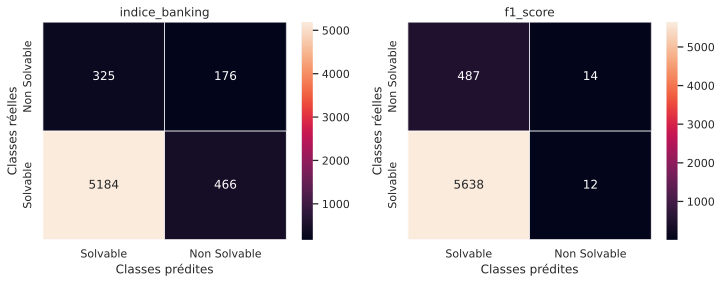

In [ ]:
mat_conf = plot_heatmap_confusion(valid_set["TARGET"],
                       **{"indice_banking": y_pred_0, "f1_score": y_pred_1})

La comparaison des deux matrices de confusion pour la métrique spécifique métier et la métrique technique, montre qu'il y a moins de clients 'True negatifs' mais également moins de 'False negatifs'. C'est à dire que plus de clients ne se sont pas vus accordés de prêts alors qu'ils étaient solvables, mais à l'inverse moins de clients ont été prédits solvables alors qu'ils ne l'étaient pas. Ce que l'on a essayé par la construction d'une métrique métier est donc vérifié. Le bilan est in fine supérieur pour la métrique métier, à condition d'avoir posé les bons poids au départ.

In [ ]:
# Calcule du gain pour la métrique bancaire
J_0 = Ind_bank(valid_set["TARGET"], y_pred_0)
# Calcul du gain pour la métrique métier
J_1 = Ind_bank(valid_set["TARGET"], y_pred_1)
print("Le gain normalisé pour la métrique banking est de {:.2f} alors qu'il est de {:.2f} pour la métrique technique"
      .format(J_0, J_1))
print("La création de la métrique banking permet un gain de {:.1f}%".format(100*(J_0 - J_1)/J_0))

Le gain normalisé pour la métrique banking est de 0.65 alors qu'il est de 0.54 pour la métrique technique
La création de la métrique banking permet un gain de 16.8%


#### 5.4.2 Précision, rappel et roc_auc <a class="anchor" id="sSection_5_4_2"></a>

Fonction de calcul du score pour les différentes métriques

In [ ]:
def calculate_multi_metrics(clf, x_valid, y_valid, threshold, *metrics):
   
    # liste des scores
    scores = []
    
    # calcule de la probabilité retourné par le modèle
    valid_proba = clf.predict_proba(x_valid)[:, 1]
    # calcule de la prédiction en fonction du threshold
    valid_predictions = (valid_proba > threshold)
    valid_predictions = np.array(valid_predictions > 0) * 1
    
    # Calcule le score pour chaque métrique
    for metric in metrics :
        scores.append(metric(y_valid, valid_predictions))
        
    return scores # retourne la liste des différents scores

In [ ]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_0 = calculate_multi_metrics(clf_0,
                                   valid_set.drop(columns=["TARGET"]),
                                   valid_set["TARGET"],
                                   best_parameters_0["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

In [ ]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_1 = calculate_multi_metrics(clf_1,
                                   valid_set.drop(columns=["TARGET"]),
                                   valid_set["TARGET"],
                                   best_parameters_1["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

Affichage graphique des scores : précision, rappel et roc_auc pour les 2 modèles optimisés

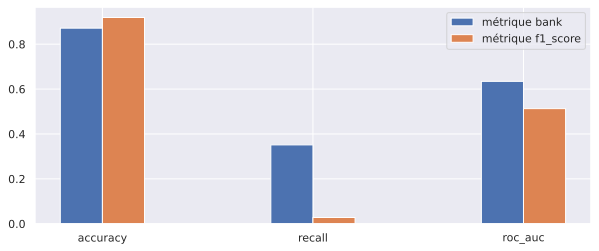

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 4))

x = np.arange(3)  # the label locations
width = 0.2  # the width of the bars

ax.bar(x - width/2, scores_0, width, label='métrique bank')

ax.bar(x + width/2, scores_1, width, label='métrique f1_score')

ax.set_xticks(x)
ax.set_xticklabels(['accuracy', 'recall', 'roc_auc'])
ax.legend()
plt.show()

L'optimisation par métrique bancaire fait perdre un peu de précision au modèle. En revanche le gain en rappel est très important, ce qui était ou à fait prédictible puisque nous avons fortement pénalisé les 'False Negatives'. Le gain est in fine plus important pour l'optimisation via la métrique bancaire comme nous l'avons vu ci-dessus.

### 5.5 Prédiction sur les données test non étiquettées <a class="anchor" id="Section_5_5"></a>

L'objectif étant de prédire la solvabilité des clients souhaitant emprunter, nous utilisons le modèle déterminé pour prédire leur solvabilité

In [ ]:
y_proba_test = clf_0.predict_proba(test_set.drop(columns=["TARGET"]))[:, 1]
y_pred_test = (y_proba_test > best_parameters_0['solvability_threshold'])
y_pred_test = np.array(y_pred_test > 0) * 1
# On remplace les valeurs 'NaN' par les prédictions du modèle
test_set["TARGET"] = y_pred_test
app_test_no_encoded = app_no_encoded.loc[app_no_encoded["TARGET"].isna()]
app_test_no_encoded.loc[:, 'TARGET'] = test_set["TARGET"]

In [ ]:
plt.title("Proportion des clients solvables")
plt.pie(test_set["TARGET"].value_counts(),
       colors=["#2ecc71", "#e74c3c"],
       autopct='%1.1f%%',
       radius=1)
plt.show()

#### Sauvegarde des prédictions

In [81]:
# Sauvegarde des prédictions
test_set.to_csv("/content/drive/MyDrive/P7_credit/output/app_test.csv")
app_test_no_encoded.to_csv("/content/drive/MyDrive/P7_credit/output/app_test_no_encoded_no_featureengineering.csv")

## 6. Importance des features <a class="anchor" id="partie6"></a>

### 6.1 Importance globale des features <a class="anchor" id="Section_6_1"></a>

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (8, 4))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
# Affichage de l'importance des features/
plot_feature_importances(feature_importance_0)

### 6.2 Analyase locale <a class="anchor" id="Section_6_2"></a>

#### 6.2.1 Clients similaires <a class="anchor" id="sSection_6_2_1"></a>

L'algorithme des plus proches voisins permet de déterminer pour chaque client quels sont les clients les plus proches avec la distance euclidienne

In [ ]:
# Transformation du jeu test
x_test_transformed = pd.DataFrame(clf_0[0].transform(x_test),
                          columns=x_test.columns,
                          index=x_test.index)

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(x_test_transformed)

# On récupère l'indice des plus proches voisins du premier client de la table
indices = nbrs.kneighbors(x_test_transformed[0:1])[1].flatten()
app_no_encoded.iloc[indices]

#### 6.2.2 Importance des features pour un client spécifique <a class="anchor" id="sSection_6_2_2"></a>

In [ ]:
lime1 = LimeTabularExplainer(x_test_transformed,
                             feature_names=x_test.columns,
                             class_names=["Solvable", "Non Solvable"],
                             discretize_continuous=False)
                            

exp = lime1.explain_instance(x_test_transformed.iloc[100],
                             clf_0.predict_proba,
                             num_samples=100)

In [ ]:
# Id client
x_test_transformed.index[100]

In [ ]:
# Affichage des résultats
exp.show_in_notebook(show_table=False)

exp.as_pyplot_figure()
plt.tight_layout()

La non solvabilité du client '100763' est supérieur au seuil de solvabilité de 0.1, donc le client est non solvable.
La variable qui joue le plus en sa défaveur est 'EXT_SOURCE_3' qui est un score normalisé provenant d'autres données. 
La variable qui joue le plus en sa faveur est 'LIVE_REGION_NOT_WORK_REGION', il ne vie pas dans la même région qu'il travaille.